In [226]:
#! conda install matplotlib -y
import numpy as np
import itertools
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

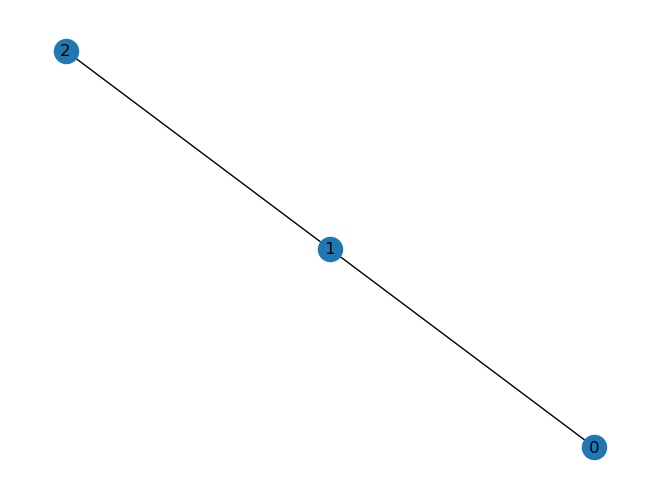

In [227]:
# Parameters
n = 3
epsilon = 1/(2*n)

# Randomness
gen = np.random.default_rng(1)

# Create a graph with n nodes
graph = nx.Graph()
graph.add_nodes_from(range(n))
graph_type = 'line' # 'random' or 'line'
if graph_type == 'complete':
    graph.add_edges_from(itertools.combinations(range(n), 2))
elif graph_type == 'line':
    graph.add_edges_from([(i, i+1) for i in range(n-1)])
elif graph_type == 'random':
    for i, j in itertools.combinations(range(n), 2):
        if gen.random() < 0.75: graph.add_edge(i, j)

# Visualize the graph
# Fix the positions of the nodes
nx.draw(graph, with_labels=True)

v_vector = gen.random(2**n)
v_vector -= v_vector[0]

## Utility Methods

In [228]:
def extract_singleton_from_vector(v_vector, n):
    single = np.zeros(n)
    for i in range(n):
        index = 2**i - 1
        single[i] = v_vector[index]
    return single

def convert_from_vector_to_dict(v_vector, n):
    v_dict = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        v_dict[subset] = v_vector[idx]
    return v_dict

def extract_singleton_from_dict(v_dict, n):
    single = np.zeros(n)
    for i in range(n):
        single[i] = v_dict[tuple([i])]
    return single

def print_labelled_matrix(P):
    df = pd.DataFrame(P)

    def subset_to_string(subset):
        return str([j for j in subset])

    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        df = df.rename(index={idx: subset_to_string(subset)})
        df = df.rename(columns={idx: subset_to_string(subset)})

    print(df)

## Computing Shapley Values

In [229]:
def compute_shapley_values_vector(n, v_vector):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                # All indices from 0 to 2**n correspond to a subset
                # Convert from a subset to the associated index
                index_wo_i = sum([2**j for j in subset])
                index_w_i = index_wo_i + 2**i
                shap_values[i] += weight * (v_vector[index_w_i] - v_vector[index_wo_i])
    return shap_values / n

def compute_shapley_values_dict(n, v_dict):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                subset = tuple(subset)
                subset_wo_i = subset
                subset_w_i = list(subset) + [i]
                subset_w_i.sort()
                subset_w_i = tuple(subset_w_i)
                shap_values[i] += weight * (v_dict[subset_w_i] - v_dict[subset_wo_i])
    return shap_values / n

## Shared Methods

In [230]:
def build_psi(n, epsilon):
    non_identity = np.zeros((2**n-1, 2**n-1))

    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        not_in_subset = [j for j in range(n) if j not in subset]
        non_identity[row_idx, row_idx] = -1 * len(not_in_subset)

        for j in not_in_subset:
           subset_with_j = subset + [j]
           subset_with_j.sort()
           subset_with_j_idx = sum([2**i for i in subset_with_j]) - 1
           non_identity[row_idx, subset_with_j_idx] = 1
           non_identity[row_idx, 2**j-1] = -1

    return np.eye(2**n-1) + epsilon * non_identity

def build_psi_graph(n, graph, epsilon):
    psi = np.zeros((2**n-1, 2**n-1))
    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            nodes_idx = sum([2**i for i in nodes]) - 1
            psi[row_idx, nodes_idx] = 1 - epsilon * len(neighbors)

            for j in neighbors:
                nodes_w_j_idx = nodes_idx + 2**j
                psi[row_idx, nodes_w_j_idx] = epsilon
                psi[row_idx, 2**j-1] = -epsilon
    return psi

def compute_next_v_graph_dict(v, n, graph, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        graph_subset = graph.subgraph(subset)
        summation = 0
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            summation += (1 - epsilon * len(neighbors)) * v[tuple(nodes)]
            for j in neighbors:
                nodes_w_j = list(nodes) + [j]
                nodes_w_j.sort()
                summation += epsilon * (v[tuple(nodes_w_j)] - v[tuple([j])])

        next_v[subset] = summation
    return next_v

def compute_next_v_dict(v, n, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        not_in_subset = [j for j in range(n) if j not in subset]
        summation = 0
        for j in not_in_subset:
            subset_with_j = list(subset) + [j]
            subset_with_j.sort()
            subset_with_j = tuple(subset_with_j)
            j = tuple([j])
            summation += v[subset_with_j] - v[j] - v[subset]

        next_v[subset] = v[subset] + epsilon * summation
    return next_v



## Limiting Matrix Method

In [231]:
shap_values = compute_shapley_values_vector(n, v_vector)
print('Method 1:', shap_values)

Psi = build_psi(n, epsilon)
next_v = v_vector[1:]

for j in range(100):
    next_v = Psi @ next_v

print('Method 2:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(100):
    next_Psi = next_Psi @ Psi

print('Method 3:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

print()

Method 1: [ 0.15937701 -0.04158696 -0.22041254]
Method 2: [ 0.15937701 -0.04158696 -0.22041254]
Method 3: [ 0.15937701 -0.04158696 -0.22041254]



## Limiting Matrix Method with Graphs

In [232]:
Psi = build_psi_graph(n, graph, epsilon)
next_v = v_vector[1:]

for j in range(50):
    next_v = Psi @ next_v

print('Method 1:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(50):
    next_Psi = next_Psi @ Psi

print('Method 2:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

Method 1: [ 0.31581764 -0.35446818 -0.06397191]
Method 2: [ 0.31581764 -0.35446818 -0.06397191]


## Limiting Direct Calculation

In [233]:
v_dict = convert_from_vector_to_dict(v_vector, n)

shap_values = compute_shapley_values_dict(n, v_dict)
print('Method 1:', shap_values)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_dict(next_v, n, epsilon)

print('Method 2:', extract_singleton_from_dict(next_v, n))

Method 1: [ 0.15937701 -0.04158696 -0.22041254]
Method 2: [ 0.15937701 -0.04158696 -0.22041254]


## Limiting Direct Calculation with Graphs

In [234]:
v_dict = convert_from_vector_to_dict(v_vector, n)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_graph_dict(next_v, n, graph, epsilon)

print('Method 1:', extract_singleton_from_dict(next_v, n))

Method 1: [ 0.31581763 -0.3544682  -0.06397192]


## Matrix in the Limit

In [235]:
def build_short_matrix(n):
    short = np.zeros((n, 2**n-1))
    for j in range(n):
        valid_items = [i for i in range(n) if j != i]
        for idx in range(2**n-1):
            subset = [i for i in range(n) if (idx + 1 >> i) & 1]
            size = len(subset)
            size_w_j = size + 1 if j not in subset else size
            #value = 0
            #for ell in range(size_w_j, n+1):
            #    value += 1/ell * (-1) ** (ell - size) \
            #        * math.comb(n - size_w_j, ell - size_w_j)
            value = -1/(math.comb(n-1, size) *n) if j not in subset else 1/(math.comb(n-1, size-1) *n)
            short[j, idx] = value
    return short

analytical_norm = []
for idx in range(2**n-1):
    subset = [i for i in range(n) if (idx+1>>i) & 1]
    s = len(subset)
    if s < n:
        l2_norm = 1 / n * 1 / math.comb(n, s) * (1 / math.comb(n-1, s-1) + 1/ math.comb(n-1, s))
    else:
        l2_norm = 1/n
    analytical_norm.append(l2_norm)

short = build_short_matrix(n)

print(np.array(analytical_norm))

print(np.linalg.norm(short, axis=0)**2)

print_labelled_matrix(short)


short @ v_vector[1:]

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.33333333]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.33333333]
             [0]       [1]    [0, 1]       [2]    [0, 2]    [1, 2]  [0, 1, 2]
[0]     0.333333 -0.166667  0.166667 -0.166667  0.166667 -0.333333   0.333333
[1]    -0.166667  0.333333  0.166667 -0.166667 -0.333333  0.166667   0.333333
[0, 1] -0.166667 -0.166667 -0.333333  0.333333  0.166667  0.166667   0.333333


array([ 0.15937701, -0.04158696, -0.22041254])

In [236]:
def build_unanimity_basis(n, is_inverse=False):
    P = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        #print(subset)
        # for all supersets of subset
        remaining = [j for j in range(n) if j not in subset]
        for length in range(len(remaining)+1):
            for new_subset in itertools.combinations(remaining, length):
                new_subset = subset + list(new_subset)
                new_subset_idx = sum([2**i for i in new_subset]) -1
                P[new_subset_idx, idx] = 1
                if is_inverse:
                    if len(new_subset) % 2 != len(subset) % 2 and len(new_subset) > len(subset):
                        P[new_subset_idx, idx] = -1
    return P

def build_triangular(n, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        if len(subset) == 1:
            triangular[idx,idx] = 1
        else:
            triangular[idx,idx] = 1 - epsilon * len(subset)
            for i in subset:
                triangular[idx - 2**i, idx] = epsilon
    return triangular

def build_triangular_graph(n, graph, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1] 
        if len(subset) == 1:
            triangular[idx,idx] = 1 
            continue
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            nodes_idx = sum([2**i for i in nodes]) - 1
            triangular[nodes_idx, idx] = 1- epsilon * len(nodes)
            for i in nodes:
                triangular[nodes_idx - 2**i, idx] += epsilon
    return triangular

def build_tri_limit(n):
    tri = np.zeros((2**n-1, 2**n-1))
    for j in range(n):
        row_idx = 2**j - 1
        valid_items = [i for i in range(n) if j != i]
        for set_size in range(n):
            for subset in itertools.combinations(valid_items, set_size):
                col_idx = sum([2**i for i in subset]) - 1 + 2**j
                tri[row_idx, col_idx] = 1/(set_size+1)
    return tri

triangular = build_triangular(n, epsilon)
triangular = build_triangular_graph(n, graph, epsilon)

empirical_tri_limit = np.linalg.matrix_power(triangular, 1000)

P = build_unanimity_basis(n)
P_inv = build_unanimity_basis(n, is_inverse=True)

tri_limit = build_tri_limit(n)
tri_limit = empirical_tri_limit

result = P @ (tri_limit @ (P_inv @ v_vector[1:]))

print(extract_singleton_from_vector(result,n))


[-0.15350423 -0.11980727 -0.53329378]


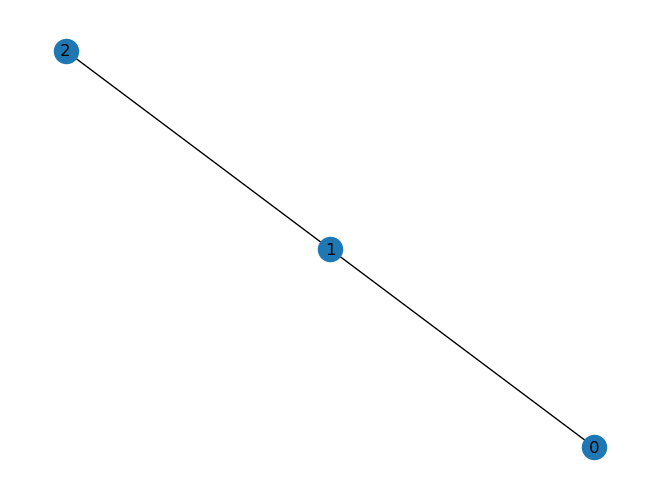

In [237]:
nx.draw(graph, with_labels=True)

In [238]:
print_labelled_matrix(build_tri_limit(n).round(2))

           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0     0.5  0.0     0.5     0.0       0.33
[1]        0.0  1.0     0.5  0.0     0.0     0.5       0.33
[0, 1]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[2]        0.0  0.0     0.0  1.0     0.5     0.5       0.33
[0, 2]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[1, 2]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[0, 1, 2]  0.0  0.0     0.0  0.0     0.0     0.0       0.00


In [239]:
print_labelled_matrix(empirical_tri_limit.round(2))

           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0     0.5  0.0    1.00     0.0       0.50
[1]        0.0  1.0     0.5  0.0    0.13     0.5       0.37
[0, 1]     0.0  0.0     0.0  0.0    0.00     0.0       0.00
[2]        0.0  0.0     0.0  1.0    1.00     0.5       0.50
[0, 2]     0.0  0.0     0.0  0.0    0.00     0.0       0.00
[1, 2]     0.0  0.0     0.0  0.0    0.00     0.0       0.00
[0, 1, 2]  0.0  0.0     0.0  0.0    0.00     0.0       0.00
